# Introduction 

### Define Problem  
The Text-to-Pandas task involves translating natural language text instructions into code that performs operations using the Pandas library, a powerful data manipulation and analysis tool in Python. The Pandas library allows users to handle data structures like DataFrames, perform filtering, aggregation, transformation, and visualization tasks, among others.

In this task, given a natural language command, the goal is to generate the correct Pandas code to achieve the desired result on a dataset, such as filtering rows, computing aggregates, or selecting specific columns.

### Challenges
 - **`Different formated dataset`** : I found 2 datasets but they were different in context column, need to reformat data and slected 2 because we don't have type in another dataset , Although the type may help the model learn better,can see data to understand `don't be confused code is easy "extract_table_creation"`

- **`Empty Text`** : Some inputs may be blank

- **`Ambiguous Text (e.g., "?" or unclear commands)`** : Instructions that are vague, incomplete, or ambiguous can lead to confusion when generating code. 
- **`Duplicate Instructions`** : When the same command is given multiple times, the model must ensure it doesn't create redundant or repeated code

In [1]:
%%time
# update and install libraries
!pip install --upgrade --quiet transformers datasets rouge_score sacrebleu wandb evaluate

CPU times: user 730 ms, sys: 166 ms, total: 896 ms
Wall time: 43.5 s


In [2]:
# import libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
from dataclasses import dataclass
import os
import gc
# 
import json
import requests
import re
from datasets import load_dataset
# 
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
# 
from evaluate import load
from transformers import T5Tokenizer, T5ForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments
# 
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import wandb
#
from kaggle_secrets import UserSecretsClient
import warnings
warnings.filterwarnings('ignore')
user_secrets = UserSecretsClient()

## Helpers

In [3]:
# var
@dataclass
class Paths:
    data_1:str = r"https://huggingface.co/datasets/hiltch/pandas-create-context/resolve/main/pandas_create_context_v1.json"
    data_2:str = r'Rahima411/text-to-pandas'
    new_checkpoint:str = 'text2pandas'
    base_model:str = 't5-base'
 
@dataclass
class trainingConfig:
    num_train_epochs: int = 5
    max_length: int = 64
   
    logging_steps: int = 50            
    evaluation_strategy: str = "steps"  
    eval_steps: int = 25              
    save_steps: int = 25              
    load_best_model_at_end: bool = True  
    greater_is_better: bool = True  
    predict_with_generate: bool = True 
    save_total_limit: int = 2
    save_strategy: str = 'steps'
    metric_for_best_model: str = "bleu"

    lr_scheduler_type: str = "cosine"
    learning_rate: float = 3e-5
    optim: str = "adamw_torch"

    auto_find_batch_size: bool = True
    per_device_train_batch_size: int = 64
    per_device_eval_batch_size: int = 32
    weight_decay: float = 0.01
    gradient_accumulation_steps: int = 4


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hf = user_secrets.get_secret("huggingface")
wb = user_secrets.get_secret("wandb")


def clear_gpu():
    print(gc.collect()) 
    torch.cuda.empty_cache()
    print(gc.collect())

In [5]:
def extract_table_creation(text:str)->(str,str):
    """
    Extracts DataFrame creation statements and questions from the given text.
    
    Args:
        text (str): The input text containing table definitions and questions.
        
    Returns:
        tuple: A tuple containing a concatenated DataFrame creation string and a question.
    """
    # Define patterns
    table_pattern = r'Table Name: (\w+) \(([\w\s,()]+)\)'
    column_pattern = r'(\w+)\s*\((object|int64|float64)\)'
    
    # Find all table names and column definitions
    matches = re.findall(table_pattern, text)
    
    # Initialize a list to hold DataFrame creation statements
    df_creations = []
    
    for table_name, columns_str in matches:
        # Extract column names
        columns = re.findall(column_pattern, columns_str)
        column_names = [col[0] for col in columns]
        
        # Format DataFrame creation statement
        df_creation = f"{table_name} = pd.DataFrame(columns={column_names})"
        df_creations.append(df_creation)
    
    # Concatenate all DataFrame creation statements
    df_creation_concat = '\n'.join(df_creations)
    
    # Extract and clean the question
    question = text[text.rindex(')')+1:].strip()
    
    return df_creation_concat, question

In [6]:
class Text2PandasDataset(Dataset):
    def __init__(self, tokenizer, question , context, labels, max_length):
        
        self.question = question  
        self.context = context  
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):

        if idx < len(self.labels):
            # Concatenate question and context with special tokens
            question = f"<question> {self.question[idx]}"
            context = f"<context> {self.context[idx]}"

            # Tokenize the inputs
            inputs = self.tokenizer(
                question + " " + context,  # Concatenated input
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            # Tokenize the labels (answer)
            labels = self.tokenizer(
                self.labels[idx], 
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            return {
                'input_ids': inputs['input_ids'].flatten().clone().detach().to(torch.long),
                'attention_mask': inputs['attention_mask'].flatten().clone().detach().to(torch.long),
                'labels': torch.tensor(labels['input_ids'].squeeze(0), dtype=torch.long),
            }
        else: 
            raise IndexError("Index out of range")
            
    

In [7]:
from sklearn.metrics import f1_score

# Load your metrics
bleu_metric = load("bleu")
rouge_metric =load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predicted_texts = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    true_texts = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Prepare references for BLEU metric
    references = [[text] for text in true_texts]  # Wrap each true text in a list

    # Calculate BLEU score
    bleu_score = bleu_metric.compute(predictions=predicted_texts, references=references)['bleu']
    
    # Calculate ROUGE score
    rouge_score = rouge_metric.compute(predictions=predicted_texts, references=true_texts)

    # Extract ROUGE scores directly
    rouge1 = rouge_score['rouge1']  # Assuming this returns a float value
    rouge2 = rouge_score['rouge2']
    rougeL = rouge_score['rougeL']

    # Calculate F1 score
    f1 = f1_score(true_texts, predicted_texts, average='weighted')  # Adjust average as needed

    return {
        'bleu': bleu_score,
        'rouge1': rouge1,
        'rouge2': rouge2,
        'rougeL': rougeL,
        'f1': f1
    }


<hr>

# Create and Process Data

In [8]:
# frist get data 1

# URL of the dataset
response = requests.get(Paths.data_1 )
data_1 = response.json()

# Example preprocessing
processed_rows = []
for row in data_1:
    # Convert dictionary to string if necessary
    if isinstance(row.get('context'), dict):
        row['context'] = json.dumps(row['context'])
    processed_rows.append(row)


In [9]:
# Convert the list of dictionaries to a DataFrame
df_1 = pd.DataFrame(data_1)

# Display the DataFrame
df_1.drop('Question',axis=1,inplace=True)
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17083 entries, 0 to 17082
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  17082 non-null  object
 1   context   17083 non-null  object
 2   answer    17083 non-null  object
dtypes: object(3)
memory usage: 400.5+ KB


In [10]:
# Ensure all entries in 'question' are strings
df_1['question'] = df_1['question'].fillna('').astype(str)

# Add a new column that contains the length of each question
df_1['question_length'] = df_1['question'].apply(lambda x: len(x) if isinstance(x, str) else np.nan)
df_1

,question,context,answer,question_length
0,How many heads of the departments are older th...,df = pd.DataFrame(columns=['age']),df[df['age'] > 56].count(),53
1,"List the name, born state and age of the heads...","df = pd.DataFrame(columns=['name', 'born_state...",df.sort_values(by='age'),77
2,"List the creation year, name and budget of eac...","df = pd.DataFrame(columns=['creation', 'name',...",df,59
3,What are the maximum and minimum budget of the...,df = pd.DataFrame(columns=['budget_in_billions']),"{'max': df['budget_in_billions'].max(), 'min':...",59
4,What is the average number of employees of the...,"df = pd.DataFrame(columns=['num_employees', 'r...",df[(df['ranking'] >= 10) & (df['ranking'] <= 1...,91
...,...,...,...,...
17078,What year was the election when the # of seats...,"df = pd.DataFrame(columns=['election', '_numbe...",df[df['_number_of_seats_won'] == 65]['election'],58
17079,What is the election year when the # of candid...,"df = pd.DataFrame(columns=['election', '_numbe...",df[df['_number_of_candidates_nominated'] == 26...,69
17080,What was the lowest # of total votes?,df = pd.DataFrame(columns=['_number_of_total_v...,df['_number_of_total_votes'].min(),37
17081,What is the strongs words compounded when the ...,df = pd.DataFrame(columns=['strongs_words_comp...,df[df['english_spelling'] == 'Jonadab']['stron...,74


In [11]:
# get data 2 
data_2 = load_dataset("Rahima411/text-to-pandas")
data_2

train.csv:   0%|          | 0.00/12.6M [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/4.10M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/57509 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/19169 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Input', 'Pandas Query'],
        num_rows: 57509
    })
    test: Dataset({
        features: ['Input', 'Pandas Query'],
        num_rows: 19169
    })
})

In [12]:
# process data and reformat to make it like data 1

# Convert the train dataset to a DataFrame
df2_train = pd.DataFrame(data_2['train'])

# Add a progress bar to the application process
tqdm.pandas(desc="Processing texts")

# Apply the function to the 'Input' column and expand the results
df2_train[['context', 'question']] = df2_train['Input'].progress_apply(extract_table_creation).apply(pd.Series)
df2_train.rename(columns={'Pandas Query': 'answer'}, inplace=True)
df2_train.drop(columns=['Input'], inplace=True)
# Add a new column that contains the length of each question
df2_train['question_length'] = df2_train['question'].apply(lambda x: len(x) if isinstance(x, str) else np.nan)
# Display the updated DataFrame
df2_train.head()


Processing texts: 100%|██████████| 57509/57509 [00:00<00:00, 63385.53it/s]


,answer,context,question,question_length
0,count = head[head['age'] > 56].shape[0],head = pd.DataFrame(columns=['age']),How many heads of the departments are older th...,53
1,"result = head.sort_values(by='age', ascending=...","head = pd.DataFrame(columns=['name', 'born_sta...","List the name, born state and age of the heads...",77
2,result = department['budget_in_billions'].agg(...,department = pd.DataFrame(columns=['budget_in_...,What are the maximum and minimum budget of the...,59
3,result = department[(department['num_employees...,department = pd.DataFrame(columns=['num_employ...,What is the average number of employees of the...,91
4,result = head[head['born_state'] > 'california...,"head = pd.DataFrame(columns=['name', 'born_sta...",What are the names of the heads who are born o...,74


In [13]:
df2_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57509 entries, 0 to 57508
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   answer           57509 non-null  object
 1   context          57509 non-null  object
 2   question         57509 non-null  object
 3   question_length  57509 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.8+ MB


In [14]:
# Convert the test dataset to a DataFrame
df2_test = pd.DataFrame(data_2['test'])

# Add a progress bar to the application process
tqdm.pandas(desc="Processing texts")

# Apply the function to the 'Input' column and expand the results
df2_test[['context', 'question']] = df2_test['Input'].progress_apply(extract_table_creation).apply(pd.Series)
df2_test.rename(columns={'Pandas Query': 'answer'}, inplace=True)
df2_test.drop(columns=['Input'], inplace=True)

# Display the updated DataFrame
df2_test.head()


Processing texts: 100%|██████████| 19169/19169 [00:00<00:00, 64109.65it/s]


,answer,context,question
0,result = table_name_22[table_name_22['team_1']...,table_name_22 = pd.DataFrame(columns=['team_1']),WHAT IS THE 2ND LEG WITH TEAM 1 OF SPORTING?
1,result = table_name_86[table_name_86['opposing...,table_name_86 = pd.DataFrame(columns=['against...,Sum of cuyo selection as the opposing team?
2,result = table_name_46[table_name_46['status']...,table_name_46 = pd.DataFrame(columns=['against...,Lowest against for tour match on 21 july 1990?
3,result = table_name_85[table_name_85['code'] >...,table_name_85 = pd.DataFrame(columns=['version...,Name the lowest version with a code of u+1034a...
4,result = table_name_21[table_name_21['version'...,table_name_21 = pd.DataFrame(columns=['charact...,What character was the version 5.1 and had a G...


In [15]:
# concat 2datafream in one 
data = pd.concat([df2_train, df_1], ignore_index=True)
data['context_length'] = data['context'].apply(lambda x: len(x) if isinstance(x, str) else np.nan)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74592 entries, 0 to 74591
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   answer           74592 non-null  object
 1   context          74592 non-null  object
 2   question         74592 non-null  object
 3   question_length  74592 non-null  int64 
 4   context_length   74592 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.8+ MB


In [16]:
data.sample(10)

,answer,context,question,question_length,context_length
60676,df_architect[df_architect.id == df_mill.archit...,"df_architect = pd.DataFrame(columns=['id', 'na...","What is the id, name and nationality of the ar...",75,116
31564,result = table_18027411_1[table_18027411_1['te...,table_18027411_1 = pd.DataFrame(columns=['team...,how many times did estudiantes de la plata par...,87,63
56462,result = table_name_7[table_name_7['record'] =...,"table_name_7 = pd.DataFrame(columns=['score', ...",What is the score of the game where the record...,57,56
7526,result = table_28194879_1[table_28194879_1['wr...,table_28194879_1 = pd.DataFrame(columns=['_num...,What is the last number in season of the episo...,72,66
62088,df[df['opponent'] == 'Cincinnati Bengals']['ti...,"df = pd.DataFrame(columns=['time___et__', 'opp...",Show all the time(et) where the opponent is th...,67,54
31171,result = table_17371135_30[table_17371135_30['...,table_17371135_30 = pd.DataFrame(columns=['col...,The player who plays goaltender is from what c...,70,91
25773,result = table_name_18[table_name_18['losses']...,table_name_18 = pd.DataFrame(columns=['points'...,What's the total number of points when the van...,110,80
64947,df[df['home_team'] == 'south melbourne']['home...,"df = pd.DataFrame(columns=['home_team_score', ...",What was South Melbourne's score when they pla...,67,59
60500,df['scientist'].nunique(),df = pd.DataFrame(columns=['scientist']),How many different scientists are assigned to ...,58,40
48489,result = table_name_73[table_name_73['launched...,table_name_73 = pd.DataFrame(columns=['launch_...,What is the total launch failures when there a...,98,83


# Exploratory Data Analysis(EDA) 

In [17]:
data.describe(include='object').T

,count,unique,top,freq
answer,74592,74045,df['Id'].count(),39
context,74592,65881,,147
question,74592,57834,?,1079


> Through this description we see that:
> - `Answer`   : `df['Id'].count()` has been repeated, but this is possible, so we do not need to dispense with these rows.
> - `Context`  : We see that it contains `147` rows that do not contain any text. We will see Through the experiment if this will affect the results negatively or positively.
> - `Question` : It is clear that the question has an invalid sample such as `?` etc.

In [18]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
question_length,74592.0,58.259264,24.435472,0.0,42.0,55.0,72.0,243.0
context_length,74592.0,67.666358,21.613270,0.0,57.0,64.0,73.0,524.0


> also ,here :
> - `context_length` confirms that there are rows that contain `no text` and it is also clear that there are rows that contain `short text that is probably invalid`.
> - `question_length` is the same as context_length  there are rows that contain `no text` and it is also clear that there are rows that contain `short text that is probably invalid`.

> **To address problem, we need to filter out rows based on multiple criteria:**

> *1. Remove rows with an invalid question, such as those containing ?.*<br>
> *2. Remove rows where context or question lengths are less than 10, which indicates too short or invalid text.*<br>
> *3. Retain the rows where the answer column may have repeated values, as this is expected behavior.*<br>
> *4. Drop duplicate rows*

In [19]:
# 1. Drop rows where the question contains "?"
data_filtered = data[~data['question'].isin(['?'])]

# 2. Drop rows where context_length or question_length is less than 10
data_filtered = data_filtered[
    (data_filtered['context_length'] >= 10) &
    (data_filtered['question_length'] >= 10)
]

#  Count the remaining rows after applying the filters
remaining_rows = data_filtered.shape[0]

#  Count the number of rows with context having no text
context_no_text_rows = data_filtered[data_filtered['context_length'] == 0].shape[0]
dropped_rows = data.shape[0]-remaining_rows


print(f"Remaining rows after filtering: {remaining_rows}, dropped  rows {dropped_rows}")
print(f"Rows where context has no text: {context_no_text_rows}")

Remaining rows after filtering: 72779, dropped  rows 1813
Rows where context has no text: 0


In [20]:
# Check for fully duplicated rows
duplicate_rows = data_filtered[data_filtered.duplicated(keep=False)]
print(f"Number of fully duplicated rows: {duplicate_rows.shape[0]}")

# 4. Drop duplicate rows, keeping the first occurrence
data_cleaned = data_filtered.drop_duplicates()

# Count the remaining rows after dropping duplicates
remaining_rows_after_duplicates = data_cleaned.shape[0]
print(f"Number of remaining rows after dropping duplicates: {remaining_rows_after_duplicates}")
print(f"Number of all rows dropped : {duplicate_rows.shape[0]+dropped_rows}")



Number of fully duplicated rows: 46
Number of remaining rows after dropping duplicates: 72756
Number of all rows dropped : 1859


In [21]:
# test df
# Filter out invalid rows based on your conditions
df2_test['question_length'] = df2_test['question'].apply(lambda x: len(x) if isinstance(x, str) else np.nan)
df2_test['context_length'] = df2_test['context'].apply(lambda x: len(x) if isinstance(x, str) else np.nan)

data_filtered = df2_test[~df2_test['question'].isin(['?'])]

df_filtered = df2_test[
    (df2_test['question_length'] > 10) &  # Ensure question length is valid
    (df2_test['context_length'] > 10) &   # Ensure context length is valid
    (df2_test['question'].str.strip() != '')  # Remove rows with empty questions
]

# Drop duplicate rows
df_filtered = df_filtered.drop_duplicates()

# Prepare df2_test (adjust as needed)
df2_test = df_filtered[['question', 'context', 'answer']]  # Select relevant columns

# Save df2_test to a CSV file
df2_test.to_csv('text2pandas_test.csv', index=False)



In [22]:
# Final Summary of the Cleaned Data
final_summary = data_cleaned.describe(include='all')

# Display the final summary
print("Final Data Summary:")
print(final_summary)

# Additional: Checking the remaining unique values for `answer`, `context`, and `question`
unique_values_summary = {
    'Unique Answers': data_cleaned['answer'].nunique(),
    'Unique Contexts': data_cleaned['context'].nunique(),
    'Unique Questions': data_cleaned['question'].nunique(),
    'Total Rows': data_cleaned.shape[0],
}

print("\nSummary of Unique Values:")
for key, value in unique_values_summary.items():
    print(f"{key}: {value}")

# Checking the percentage of missing or empty context and question
missing_context_percentage = (data_cleaned['context_length'] == 0).sum() / data_cleaned.shape[0] * 100
missing_question_percentage = (data_cleaned['question_length'] == 0).sum() / data_cleaned.shape[0] * 100

print(f"\nPercentage of rows with missing/empty context: {missing_context_percentage:.2f}%")
print(f"Percentage of rows with missing/empty question: {missing_question_percentage:.2f}%")


Final Data Summary:
                  answer                            context    question  \
count              72756                              72756       72756   
unique             72234                              64295       57412   
top     df['Id'].count()  df = pd.DataFrame(columns=['Id'])  unopposed?   
freq                  38                                127          18   
mean                 NaN                                NaN         NaN   
std                  NaN                                NaN         NaN   
min                  NaN                                NaN         NaN   
25%                  NaN                                NaN         NaN   
50%                  NaN                                NaN         NaN   
75%                  NaN                                NaN         NaN   
max                  NaN                                NaN         NaN   

        question_length  context_length  
count      72756.000000    72756.0000

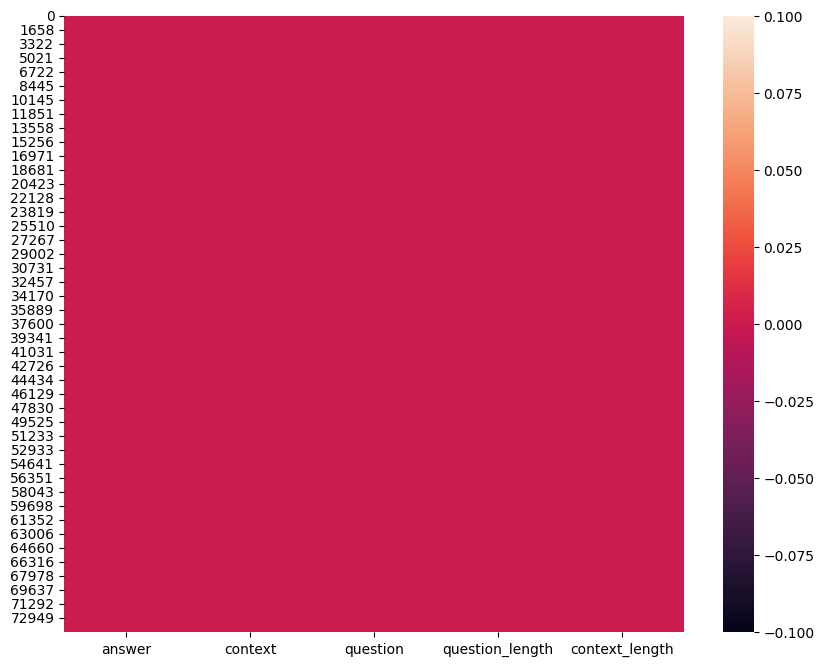

In [23]:
# heatmap to check nans
plt.figure(figsize=(10, 8)) 
sns.heatmap(data_cleaned.isnull())
plt.show()

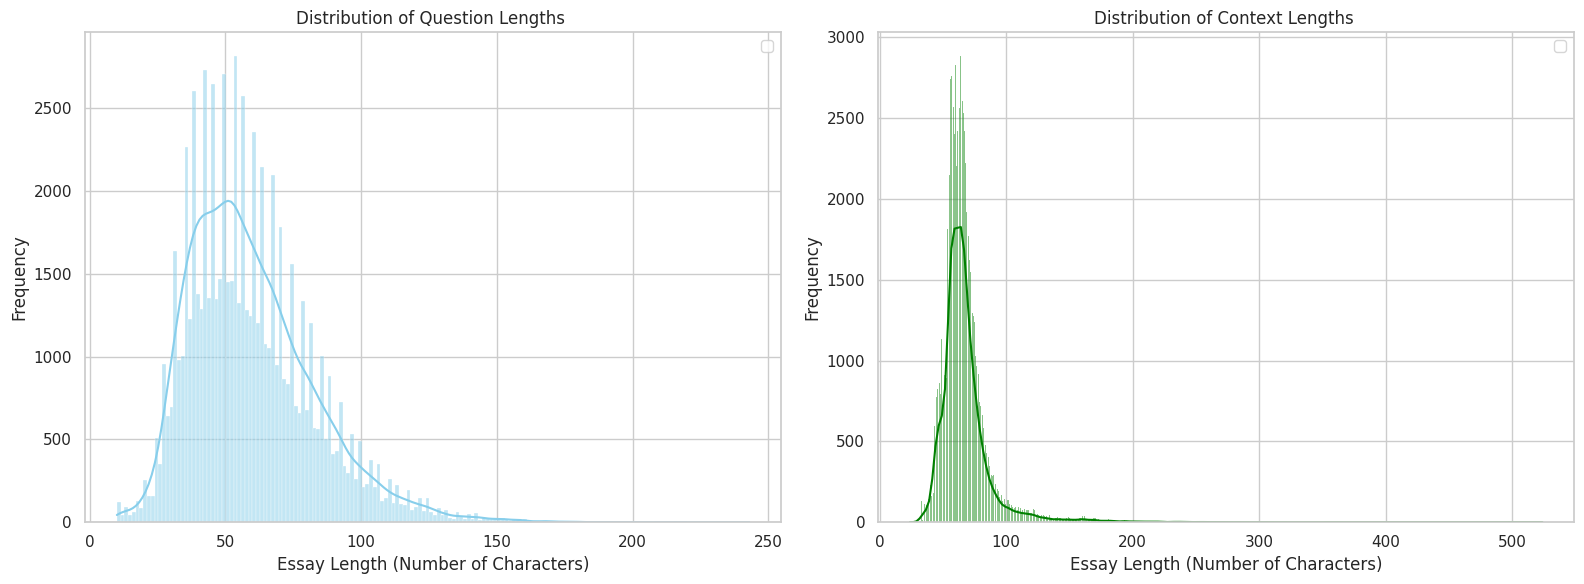

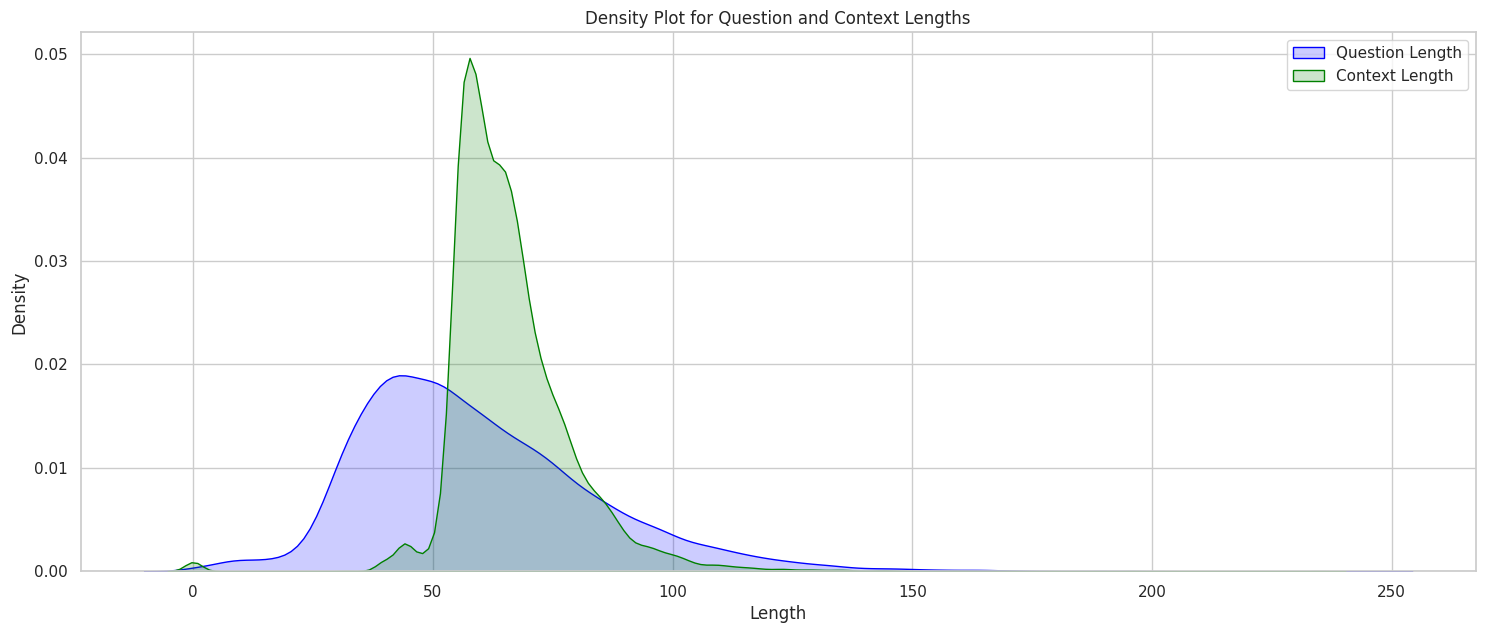

In [24]:
# Distribution of `question_length` and `context_length`

sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.histplot(data_cleaned['question_length'], color="skyblue", kde=True)
plt.title('Distribution of Question Lengths ')
plt.xlabel('Essay Length (Number of Characters)')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1,2,2)
sns.histplot(data_cleaned['context_length'], color="green", kde=True)
plt.title('Distribution of Context Lengths ')
plt.xlabel('Essay Length (Number of Characters)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()



#  Density Plot for Question and Context Lengths
plt.figure(figsize=(18, 7))
sns.kdeplot(data_filtered['question_length'], label='Question Length', color='blue', fill=True, alpha=0.2)
sns.kdeplot(data_filtered['context_length'], label='Context Length', color='green', fill=True, alpha=0.2)
plt.title('Density Plot for Question and Context Lengths')
plt.xlabel('Length')
plt.ylabel('Density')
plt.legend()
plt.show()

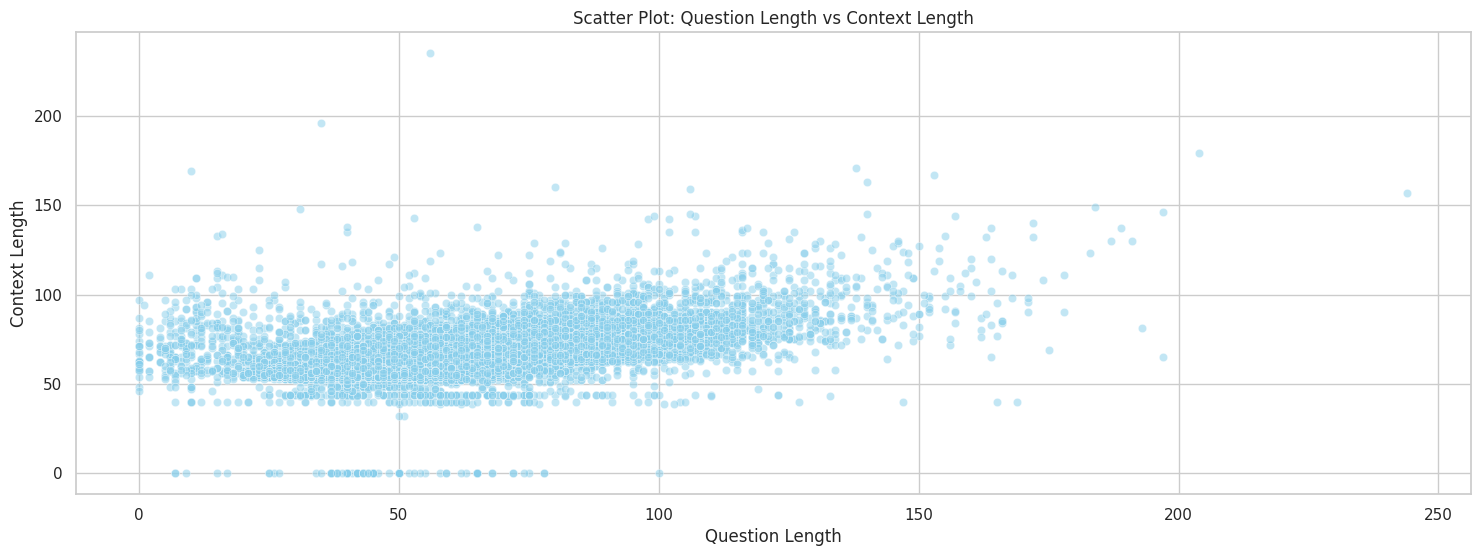

In [25]:
# Scatter Plot with Custom Color
plt.figure(figsize=(18, 6))
sns.scatterplot(x=data_filtered['question_length'], y=data_filtered['context_length'], alpha=0.5, color='skyblue')  
plt.title('Scatter Plot: Question Length vs Context Length')
plt.xlabel('Question Length')
plt.ylabel('Context Length')
plt.show()


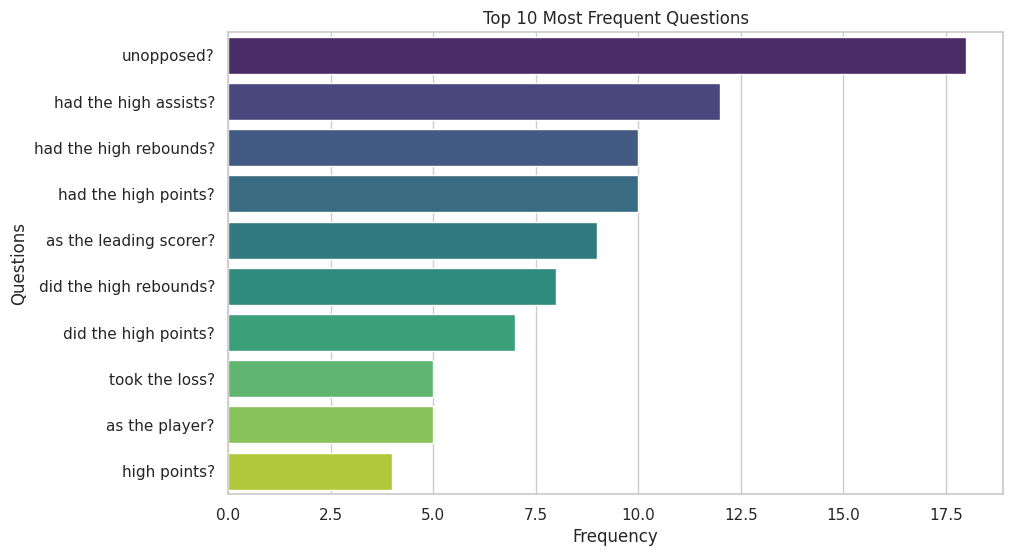

In [26]:
# Bar plot of most frequent `question` entries (Top 10)
plt.figure(figsize=(10, 6))
top_questions = data_cleaned['question'].value_counts().head(10)
sns.barplot(x=top_questions.values, y=top_questions.index, palette='viridis')
plt.title('Top 10 Most Frequent Questions')
plt.xlabel('Frequency')
plt.ylabel('Questions')
plt.show()

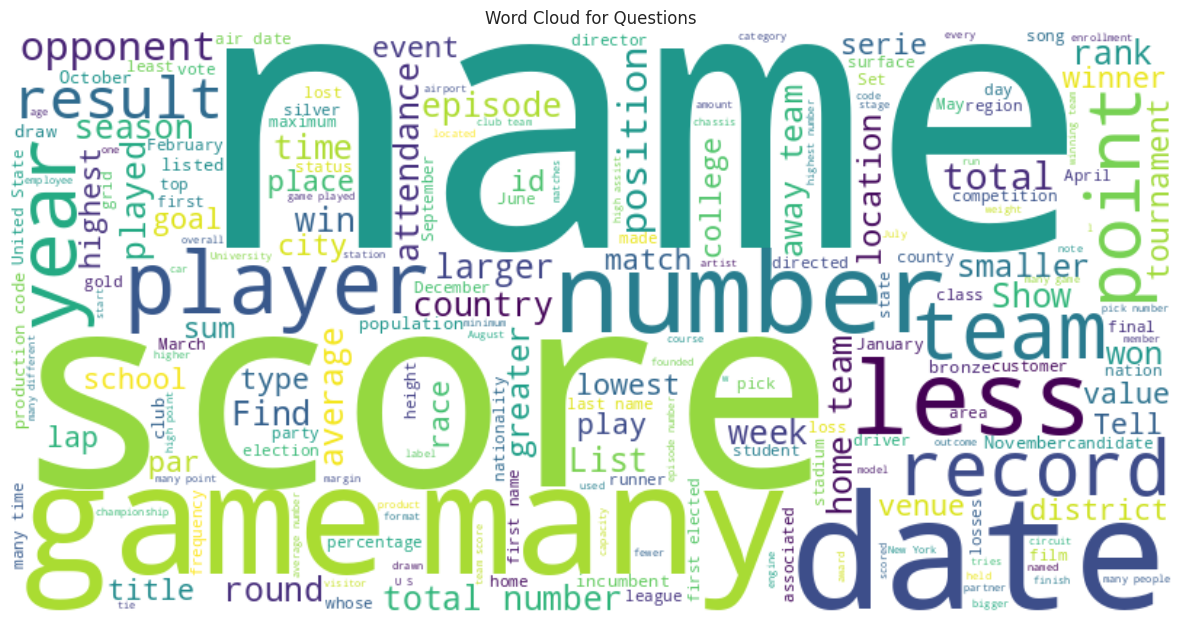

In [27]:
# Word Cloud for Questions
question_text = ' '.join(data_cleaned['question'].dropna().values)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(question_text)

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Questions')
plt.show()

In [28]:
# save in csv
output_file = 'Text2Pandas_Cleand.csv'
data_cleaned.to_csv(output_file, index=False)
print(f"Cleaned data saved to {output_file}")

Cleaned data saved to Text2Pandas_Cleand.csv


In [29]:
print(len(dir()))  
del  WordCloud, wordcloud, data,data_1, data_2, data_filtered,remaining_rows_after_duplicates,top_questions,unique_values_summary
del df2_train, df_1, dropped_rows, duplicate_rows, final_summary,missing_context_percentage,missing_question_percentage
print(len(dir()))  
print('delete variables')

124
108
delete variables


<hr>

In [30]:
# login wandb
os.environ["WANDB_API_KEY"] = wb
os.environ["WANDB_DEBUG"] = "true"
os.environ["WANDB_PROJECT"]=Paths.new_checkpoint
os.environ["WANDB_NAME"] = f'{Paths.new_checkpoint}-r1'
wandb.init()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ziayd-usf (daigt_team). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240921_152736-yqtu1cs8
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run text2pandas-r1
wandb: ⭐️ View project at https://wandb.ai/daigt_team/text2pandas
wandb: 🚀 View run at https://wandb.ai/daigt_team/text2pandas/runs/yqtu1cs8


In [31]:
# Load model and tokenizer
tokenizer = T5Tokenizer.from_pretrained(Paths.base_model)
model = T5ForConditionalGeneration.from_pretrained(Paths.base_model)
model.to(device);

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [32]:
# Define the additional special tokens
special_tokens_dict = {'additional_special_tokens': ['<question>', '<context>']}

# Add the special tokens to the tokenizer
tokenizer.add_special_tokens(special_tokens_dict)

print(tokenizer.all_special_tokens)

['</s>', '<unk>', '<pad>', '<question>', '<context>']


# Prepare data to train

In [33]:
# split data to train and eval
X_train, X_val, y_train, y_val = train_test_split(data_cleaned[['question' , 'context' ]], data_cleaned['answer'], test_size=0.2, random_state=45,)
X_train.shape , y_val.shape 

((58204, 2), (14552,))

In [34]:
# prepare data to trainging process
train_dataset = Text2PandasDataset(tokenizer,X_train['question'].to_list(), X_train['context'].to_list(),y_train.to_list(),trainingConfig.max_length)
eval_dataset = Text2PandasDataset(tokenizer,X_val['question'].to_list(), X_val['context'].to_list(),y_val.to_list(),trainingConfig.max_length)

In [35]:
train_dataset[0]

{'input_ids': tensor([32100,   363,    19,     8,  2637,    13,     8,  4757,   917,    30,
          2628,  5947, 10106,    58, 32101,     3,    26,    89,  3274,     3,
           102,    26,     5, 20367,   371,  2375,    15,   599,  3297,   440,
            29,     7,  2423,  6306,    31,  8547,   302,    31,     6,     3,
            31, 12066,  2009,   834, 12251,    31,   908,    61,     1,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([    3,    26,    89,  6306,    26,    89,     5, 12066,  2009,   834,
         12251,  3274,  2423,     3,    31, 16128,  5947, 10106,    31,  4275,
          8547,   302,     5,    23,  5133,  6306,   632,   908,   

# Train Model

In [36]:
# init config
training_args = Seq2SeqTrainingArguments(
    
    output_dir=Paths.new_checkpoint,
    num_train_epochs=trainingConfig.num_train_epochs,
    
    evaluation_strategy=trainingConfig.evaluation_strategy,  
    eval_steps=trainingConfig.eval_steps,               
    logging_steps=trainingConfig.logging_steps,             
    save_steps=trainingConfig.save_steps,               
    load_best_model_at_end=trainingConfig.load_best_model_at_end,  
    metric_for_best_model=trainingConfig.metric_for_best_model, 
    greater_is_better=trainingConfig.greater_is_better,
    save_strategy =trainingConfig.save_strategy,
    predict_with_generate=trainingConfig.predict_with_generate, 
    save_total_limit=trainingConfig.save_total_limit,
    
    lr_scheduler_type=trainingConfig.lr_scheduler_type,
    learning_rate=trainingConfig.learning_rate,
    optim=trainingConfig.optim,
    
    auto_find_batch_size=trainingConfig.auto_find_batch_size,
    per_device_train_batch_size=trainingConfig.per_device_train_batch_size,
    per_device_eval_batch_size=trainingConfig.per_device_eval_batch_size,
    weight_decay=trainingConfig.weight_decay,
    gradient_accumulation_steps=trainingConfig.gradient_accumulation_steps,
    
    push_to_hub=True,
    hub_private_repo=True,
    hub_token=hf,

    report_to=['wandb'],
)
clear_gpu()

7892
60629


In [37]:
# inti trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics  
)

In [38]:
# train
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Bleu,Rouge1,Rouge2,Rougel,F1
25,No log,0.973827,0.000000,0.002110,0.001399,0.002084,0.000000
50,2.487900,0.393833,0.254796,0.639047,0.578626,0.635344,0.000000
75,2.487900,0.289064,0.350988,0.722373,0.656088,0.719752,0.000000
100,0.386600,0.240212,0.348080,0.739453,0.673490,0.736705,0.000000
125,0.386600,0.214230,0.348243,0.740194,0.676603,0.737433,0.000000
150,0.275100,0.194946,0.349470,0.741326,0.679011,0.738839,0.000000
175,0.275100,0.179684,0.349819,0.741666,0.679850,0.739092,0.000000
200,0.231500,0.167540,0.350382,0.742225,0.680462,0.739893,0.000000
225,0.231500,0.158156,0.350661,0.742556,0.681211,0.740098,0.000000
250,0.206800,0.149734,0.350943,0.743384,0.682042,0.740952,0.000000


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=1135, training_loss=0.271031905691004, metrics={'train_runtime': 19314.603, 'train_samples_per_second': 15.067, 'train_steps_per_second': 0.059, 'total_flos': 2.210638934310912e+16, 'train_loss': 0.271031905691004, 'epoch': 4.989010989010989})

In [39]:
# eval
trainer.evaluate()
clear_gpu()

0
0


---

In [40]:
df2_test

,question,context,answer
0,WHAT IS THE 2ND LEG WITH TEAM 1 OF SPORTING?,table_name_22 = pd.DataFrame(columns=['team_1']),result = table_name_22[table_name_22['team_1']...
1,Sum of cuyo selection as the opposing team?,table_name_86 = pd.DataFrame(columns=['against...,result = table_name_86[table_name_86['opposing...
2,Lowest against for tour match on 21 july 1990?,table_name_46 = pd.DataFrame(columns=['against...,result = table_name_46[table_name_46['status']...
3,Name the lowest version with a code of u+1034a...,table_name_85 = pd.DataFrame(columns=['version...,result = table_name_85[table_name_85['code'] >...
4,What character was the version 5.1 and had a G...,table_name_21 = pd.DataFrame(columns=['charact...,result = table_name_21[table_name_21['version'...
...,...,...,...
19164,What time was the match played with a score of...,"table_name_35 = pd.DataFrame(columns=['time', ...",result = table_name_35[table_name_35['score'] ...
19165,On which ground did the team play Aston Villa?,table_name_83 = pd.DataFrame(columns=['ground'...,result = table_name_83[table_name_83['opponent...
19166,What kind of competition was it at San Siro at...,table_name_60 = pd.DataFrame(columns=['competi...,result = table_name_60[table_name_60['ground']...
19167,What is the total number of decile for the red...,table_name_34 = pd.DataFrame(columns=['decile'...,result = table_name_34[table_name_34['name'] =...


In [41]:
test_dataset = Text2PandasDataset(tokenizer,df2_test['question'].to_list(), df2_test['context'].to_list(),df2_test['answer'].to_list(),trainingConfig.max_length)
test_dataset[0]

{'input_ids': tensor([32100, 21665,  6827,  1853,   204, 10604,   301,  8579, 11951,   332,
         22684,   209,  3347,   180, 14536,  2365,    58, 32101,   953,   834,
          4350,   834,  2884,  3274,     3,   102,    26,     5, 20367,   371,
          2375,    15,   599,  3297,   440,    29,     7,  2423,  6306,    31,
         11650,   834,   536,    31,   908,    61,     1,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([  741,  3274,   953,   834,  4350,   834,  2884,  6306,  3869,   834,
          4350,   834,  2884,  6306,    31, 11650,   834,   536,    31,   908,
          3274,  2423,    96,  6661,    53,   121,   908,  6306,  6

In [42]:
test_results = trainer.predict(test_dataset)
test_results

PredictionOutput(predictions=array([[    0,   741,  3274, ...,   834,   536,    31],
       [    0,   741,  3274, ...,     7,    53,   834],
       [    0,   741,  3274, ...,   302,    31,   908],
       ...,
       [    0,   741,  3274, ...,    31,   908,  3274],
       [    0,   741,  3274, ...,    31,   908,  3274],
       [    0,   741,  3274, ..., 21560,    31,   908]]), label_ids=array([[ 741, 3274,  953, ...,    0,    0,    0],
       [ 741, 3274,  953, ...,    0,    0,    0],
       [ 741, 3274,  953, ...,    0,    0,    0],
       ...,
       [ 741, 3274,  953, ...,    0,    0,    0],
       [ 741, 3274,  953, ...,    0,    0,    0],
       [ 741, 3274,  953, ...,    0,    0,    0]]), metrics={'test_loss': 0.046332042664289474, 'test_bleu': 0.47289964095686976, 'test_rouge1': 0.8395707943473678, 'test_rouge2': 0.8199794260531272, 'test_rougeL': 0.8395698270839866, 'test_f1': 0.0, 'test_runtime': 404.4101, 'test_samples_per_second': 45.926, 'test_steps_per_second': 1.437})

In [43]:
print('Prediction Loss : ',test_results.metrics['test_loss'])
print('Prediction Rouge1 : ',test_results.metrics['test_rouge1'])
print('Prediction Rouge2 : ',test_results.metrics['test_rouge2'])
print('Prediction RougeL : ',test_results.metrics['test_rougeL'])
print('Prediction Bleu : ',test_results.metrics['test_bleu'])
print('Prediction F1 : ',test_results.metrics['test_f1'])

Prediction Loss :  0.046332042664289474
Prediction Rouge1 :  0.8395707943473678
Prediction Rouge2 :  0.8199794260531272
Prediction RougeL :  0.8395698270839866
Prediction Bleu :  0.47289964095686976
Prediction F1 :  0.0


In [44]:
# test samples

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def generate_text(input_text, model, tokenizer, max_length=512):
    # Tokenize the input text
    inputs = tokenizer.encode(input_text, return_tensors="pt", truncation=True, max_length=max_length)
    
    # Move input tensors to the same device as the model
    inputs = inputs.to(device)
    model.to(device)

    # Generate predictions
    with torch.no_grad():  # Ensure no gradients are computed for inference
        outputs = model.generate(inputs, max_length=max_length, num_beams=4, early_stopping=True)
    
    # Decode the generated text
    predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return predicted_text

In [45]:
question = f"<question> what is the total amount of players for the rockets in 1998 only?"
context = f"<context> df = pd.DataFrame(columns=['player', 'years_for_rockets'])"
input_text =question+" "+context

# Generate and print the predicted text
predicted_text = generate_text(input_text, model, tokenizer)
print(predicted_text)

df[df['years_for_rockets'] == '1998']['player'].count()


In [46]:
question = f"<question> what is the total amount of players for the rockets in 1998 only?"
context = f"<context> df = pd.DataFrame(columns=['player', 'years_for_rockets'])"
input_text =question+" "+context

# Generate and print the predicted text
predicted_text = generate_text(input_text, model, tokenizer)
print(predicted_text)

df[df['years_for_rockets'] == '1998']['player'].count()


In [47]:
question = f"<question> WHAT IS THE RECORD FOR THE GAME SMALLER THAN 31?"
context = f"<context> df = pd.DataFrame(columns=['record', 'game'])"
input_text =question+" "+context

# Generate and print the predicted text
predicted_text = generate_text(input_text, model, tokenizer)
print(predicted_text)

# Answer: df.loc[df['game'] < 31, 'record']

df[df['game'] > 31]['record'].values[0]


In [48]:
question = f"<question> What is the max value for counter_2 for all of the cells?"
context = f"<context> df = pd.DataFrame(columns=['cell_no', 'counter_2'])"
input_text =question+" "+context

# Generate and print the predicted text
predicted_text = generate_text(input_text, model, tokenizer)
print(predicted_text)

df[df['counter_2'] == 'all']['cell_no']
